Based off Thrones2Vec by © Yuriy Guts, 2016
https://github.com/YuriyGuts/thrones2vec

## Imports

In [4]:
import logging
import multiprocessing
import os
import re

In [5]:
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from nltk.corpus import stopwords

In [6]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/zingbretsen/anaconda3/envs/word2vec/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


**Set up logging**

In [7]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

**Download NLTK tokenizer models (only the first time)**

In [8]:
nltk.download("punkt")
nltk.download("stopwords")
stops = stopwords.words('english')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/zingbretsen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zingbretsen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
#convert into a list of words
#rtemove unnnecessary,, split into words, no hyphens
#list of words
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return [word.lower() for word in words if word not in stops]

## Prepare Corpus

In [2]:
fname = '/root/datasets/wiki_clean.txt'
corpus_raw = u""

with open(fname, "r", encoding="utf-8") as f:
    corpus_raw += f.read()

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

raw_sentences = tokenizer.tokenize(corpus_raw)
del corpus_raw

#sentence where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))
del raw_sentences

token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))



In [20]:
#ONCE we have vectors
#step 3 - build model
#3 main tasks that vectors help with
#DISTANCE, SIMILARITY, RANKING

# Dimensionality of the resulting word vectors.
#more dimensions, more computationally expensive to train
#but also more accurate
#more dimensions = more generalized
num_features = 300
# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
#more workers, faster we train
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7

# Downsample setting for frequent words.
#0 - 1e-5 is good for this
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
#random number generator
#deterministic, good for debugging
seed = 1

model = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [21]:
model.build_vocab(sentences)

2018-04-14 23:36:36,026 : INFO : collecting all words and their counts
2018-04-14 23:36:36,029 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-04-14 23:36:36,037 : INFO : collected 2674 word types from a corpus of 26026 raw words and 1827 sentences
2018-04-14 23:36:36,038 : INFO : Loading a fresh vocabulary
2018-04-14 23:36:36,046 : INFO : min_count=3 retains 1172 unique words (43% of original 2674, drops 1502)
2018-04-14 23:36:36,046 : INFO : min_count=3 leaves 24104 word corpus (92% of original 26026, drops 1922)
2018-04-14 23:36:36,051 : INFO : deleting the raw counts dictionary of 2674 items
2018-04-14 23:36:36,054 : INFO : sample=0.001 downsamples 70 most-common words
2018-04-14 23:36:36,055 : INFO : downsampling leaves estimated 17503 word corpus (72.6% of prior 24104)
2018-04-14 23:36:36,059 : INFO : estimated required memory for 1172 words and 300 dimensions: 3398800 bytes
2018-04-14 23:36:36,059 : INFO : resetting layer weights


In [330]:
total_words = len(model.wv.vocab)
print("Word2Vec vocabulary length:", total_words)

Word2Vec vocabulary length: 19608


**Start training, this might take a minute or two...**

In [331]:
model.train(sentences, total_words=token_count, epochs=50)
del sentences

if not os.path.exists("trained"):
    os.makedirs("trained")

model.save(os.path.join("trained", "model.w2v"))

2018-04-14 19:37:09,707 : INFO : training model with 8 workers on 19608 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
2018-04-14 19:37:10,740 : INFO : EPOCH 1 - PROGRESS: at 25.20% words, 324627 words/s, in_qsize 16, out_qsize 1
2018-04-14 19:37:11,771 : INFO : EPOCH 1 - PROGRESS: at 54.72% words, 348704 words/s, in_qsize 15, out_qsize 0
2018-04-14 19:37:12,802 : INFO : EPOCH 1 - PROGRESS: at 87.82% words, 371817 words/s, in_qsize 14, out_qsize 1
2018-04-14 19:37:13,016 : INFO : worker thread finished; awaiting finish of 7 more threads
2018-04-14 19:37:13,049 : INFO : worker thread finished; awaiting finish of 6 more threads
2018-04-14 19:37:13,053 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-04-14 19:37:13,073 : INFO : worker thread finished; awaiting finish of 4 more threads
2018-04-14 19:37:13,116 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-04-14 19:37:13,129 : INFO : worker thread finished; await

2018-04-14 19:37:34,684 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-04-14 19:37:34,719 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-04-14 19:37:34,738 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-04-14 19:37:34,738 : INFO : EPOCH - 7 : training on 1388032 raw words (1304555 effective words) took 4.1s, 315233 effective words/s
2018-04-14 19:37:35,761 : INFO : EPOCH 8 - PROGRESS: at 18.72% words, 244448 words/s, in_qsize 15, out_qsize 2
2018-04-14 19:37:36,770 : INFO : EPOCH 8 - PROGRESS: at 41.76% words, 270747 words/s, in_qsize 14, out_qsize 1
2018-04-14 19:37:37,793 : INFO : EPOCH 8 - PROGRESS: at 66.96% words, 287575 words/s, in_qsize 16, out_qsize 0
2018-04-14 19:37:38,868 : INFO : EPOCH 8 - PROGRESS: at 95.02% words, 301037 words/s, in_qsize 7, out_qsize 1
2018-04-14 19:37:38,870 : INFO : worker thread finished; awaiting finish of 7 more threads
2018-04-14 19:37:38,881 : INFO : worker thread finished;

2018-04-14 19:38:02,534 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-04-14 19:38:02,557 : INFO : worker thread finished; awaiting finish of 4 more threads
2018-04-14 19:38:02,561 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-04-14 19:38:02,563 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-04-14 19:38:02,587 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-04-14 19:38:02,599 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-04-14 19:38:02,600 : INFO : EPOCH - 14 : training on 1388032 raw words (1304250 effective words) took 3.9s, 338589 effective words/s
2018-04-14 19:38:03,668 : INFO : EPOCH 15 - PROGRESS: at 23.04% words, 286678 words/s, in_qsize 15, out_qsize 0
2018-04-14 19:38:04,696 : INFO : EPOCH 15 - PROGRESS: at 51.12% words, 320474 words/s, in_qsize 15, out_qsize 0
2018-04-14 19:38:05,716 : INFO : EPOCH 15 - PROGRESS: at 77.76% words, 326874 words/s, in_qs

2018-04-14 19:38:29,005 : INFO : EPOCH 21 - PROGRESS: at 77.76% words, 330729 words/s, in_qsize 15, out_qsize 0
2018-04-14 19:38:29,669 : INFO : worker thread finished; awaiting finish of 7 more threads
2018-04-14 19:38:29,683 : INFO : worker thread finished; awaiting finish of 6 more threads
2018-04-14 19:38:29,731 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-04-14 19:38:29,748 : INFO : worker thread finished; awaiting finish of 4 more threads
2018-04-14 19:38:29,758 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-04-14 19:38:29,759 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-04-14 19:38:29,760 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-04-14 19:38:29,781 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-04-14 19:38:29,782 : INFO : EPOCH - 21 : training on 1388032 raw words (1304674 effective words) took 3.8s, 339319 effective words/s
2018-04-14 19:38:30,85

2018-04-14 19:38:55,597 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-04-14 19:38:55,611 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-04-14 19:38:55,618 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-04-14 19:38:55,646 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-04-14 19:38:55,647 : INFO : EPOCH - 27 : training on 1388032 raw words (1304800 effective words) took 4.6s, 281201 effective words/s
2018-04-14 19:38:56,740 : INFO : EPOCH 28 - PROGRESS: at 19.44% words, 241449 words/s, in_qsize 15, out_qsize 0
2018-04-14 19:38:57,808 : INFO : EPOCH 28 - PROGRESS: at 42.48% words, 261059 words/s, in_qsize 16, out_qsize 0
2018-04-14 19:38:58,842 : INFO : EPOCH 28 - PROGRESS: at 66.96% words, 276647 words/s, in_qsize 15, out_qsize 0
2018-04-14 19:38:59,847 : INFO : EPOCH 28 - PROGRESS: at 90.70% words, 284026 words/s, in_qsize 13, out_qsize 0
2018-04-14 19:39:00,097 : INFO : worker thread fin

2018-04-14 19:39:23,671 : INFO : EPOCH - 33 : training on 1388032 raw words (1304735 effective words) took 4.5s, 290429 effective words/s
2018-04-14 19:39:24,736 : INFO : EPOCH 34 - PROGRESS: at 18.00% words, 225913 words/s, in_qsize 15, out_qsize 0
2018-04-14 19:39:25,768 : INFO : EPOCH 34 - PROGRESS: at 42.48% words, 266967 words/s, in_qsize 15, out_qsize 0
2018-04-14 19:39:26,778 : INFO : EPOCH 34 - PROGRESS: at 66.24% words, 279790 words/s, in_qsize 15, out_qsize 0
2018-04-14 19:39:27,800 : INFO : EPOCH 34 - PROGRESS: at 90.70% words, 287543 words/s, in_qsize 13, out_qsize 0
2018-04-14 19:39:28,023 : INFO : worker thread finished; awaiting finish of 7 more threads
2018-04-14 19:39:28,046 : INFO : worker thread finished; awaiting finish of 6 more threads
2018-04-14 19:39:28,086 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-04-14 19:39:28,113 : INFO : worker thread finished; awaiting finish of 4 more threads
2018-04-14 19:39:28,123 : INFO : worker thread fin

2018-04-14 19:39:53,150 : INFO : EPOCH 40 - PROGRESS: at 75.60% words, 317673 words/s, in_qsize 16, out_qsize 0
2018-04-14 19:39:54,053 : INFO : worker thread finished; awaiting finish of 7 more threads
2018-04-14 19:39:54,070 : INFO : worker thread finished; awaiting finish of 6 more threads
2018-04-14 19:39:54,080 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-04-14 19:39:54,104 : INFO : worker thread finished; awaiting finish of 4 more threads
2018-04-14 19:39:54,120 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-04-14 19:39:54,124 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-04-14 19:39:54,204 : INFO : EPOCH 40 - PROGRESS: at 99.28% words, 311287 words/s, in_qsize 1, out_qsize 1
2018-04-14 19:39:54,205 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-04-14 19:39:54,207 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-04-14 19:39:54,208 : INFO : EPOCH - 40 : tra

2018-04-14 19:40:19,616 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-04-14 19:40:19,636 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-04-14 19:40:19,637 : INFO : EPOCH - 46 : training on 1388032 raw words (1304244 effective words) took 3.8s, 341938 effective words/s
2018-04-14 19:40:20,689 : INFO : EPOCH 47 - PROGRESS: at 23.76% words, 300715 words/s, in_qsize 16, out_qsize 0
2018-04-14 19:40:21,755 : INFO : EPOCH 47 - PROGRESS: at 53.28% words, 330683 words/s, in_qsize 15, out_qsize 0
2018-04-14 19:40:22,757 : INFO : EPOCH 47 - PROGRESS: at 79.90% words, 335624 words/s, in_qsize 15, out_qsize 0
2018-04-14 19:40:23,364 : INFO : worker thread finished; awaiting finish of 7 more threads
2018-04-14 19:40:23,380 : INFO : worker thread finished; awaiting finish of 6 more threads
2018-04-14 19:40:23,426 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-04-14 19:40:23,439 : INFO : worker thread finished; awaiting finis

(65225427, 69401600)

## Explore the trained model.

In [334]:
model = w2v.Word2Vec.load(os.path.join("trained", "model.w2v"))

2018-04-14 19:41:08,487 : INFO : loading Word2Vec object from trained/thrones2vec.w2v
2018-04-14 19:41:08,972 : INFO : loading wv recursively from trained/thrones2vec.w2v.wv.* with mmap=None
2018-04-14 19:41:08,972 : INFO : setting ignored attribute vectors_norm to None
2018-04-14 19:41:08,974 : INFO : loading vocabulary recursively from trained/thrones2vec.w2v.vocabulary.* with mmap=None
2018-04-14 19:41:08,974 : INFO : loading trainables recursively from trained/thrones2vec.w2v.trainables.* with mmap=None
2018-04-14 19:41:08,975 : INFO : setting ignored attribute cum_table to None
2018-04-14 19:41:08,976 : INFO : loaded trained/thrones2vec.w2v


### Compress the word vectors into 2D space and plot them

In [335]:
#my video - how to visualize a dataset easily
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0, verbose=1, perplexity=40, n_iter=300)

In [336]:
all_word_vectors_matrix = model.wv.syn0

/Users/zingbretsen/anaconda3/envs/word2vec/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


In [337]:
SIZE = 10000
perm = np.random.permutation(SIZE)

**Train t-SNE, this could take a minute or two...**

In [338]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix[perm, :])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.167s...
[t-SNE] Computed neighbors for 10000 samples in 55.165s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.473592
[t-SNE] KL divergence after 250 iterations with early exaggeration: 158.505524
[t-SNE] Error after 300 iterations: 7.195434


**Plot the big picture**

In [339]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (model.wv.index2word[n], all_word_vectors_matrix_2d[i])
            for i, n in enumerate(perm)
        ] if abs(coords[0]) < 10 and abs(coords[1]) < 10
    ],
    columns=["word", "x", "y"]
)

In [340]:
sns.set_context("poster")

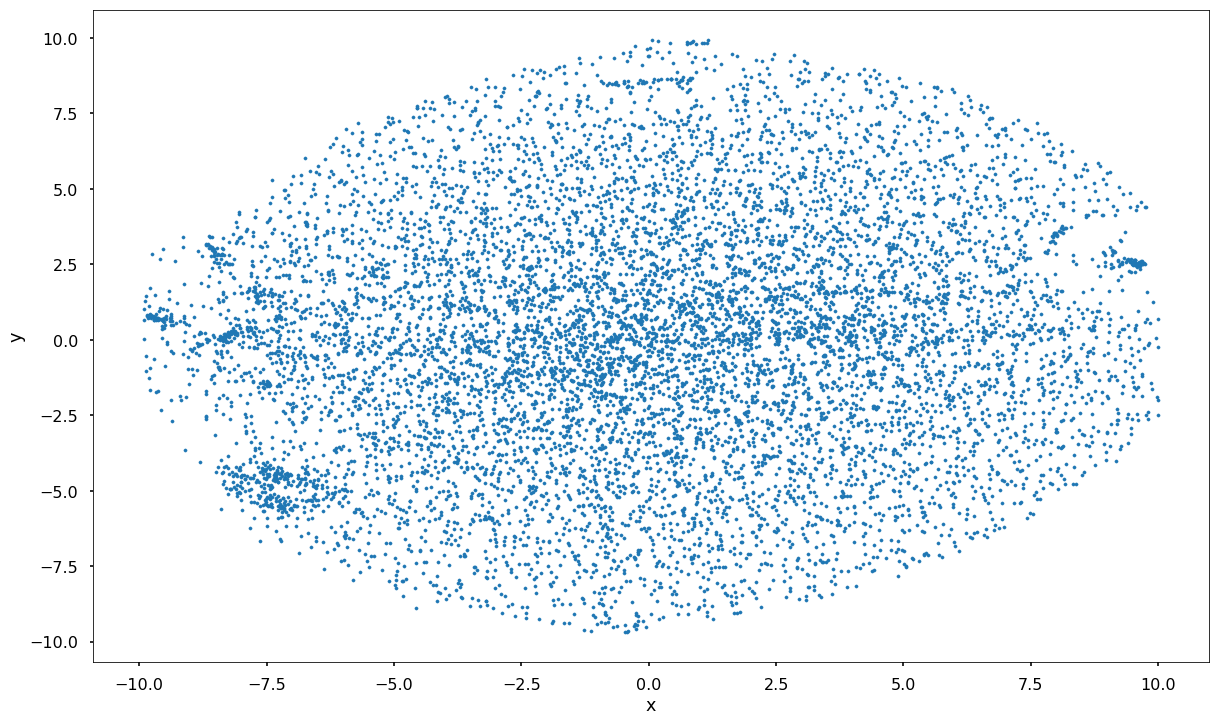

In [341]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

**Zoom in to some interesting places**

In [342]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

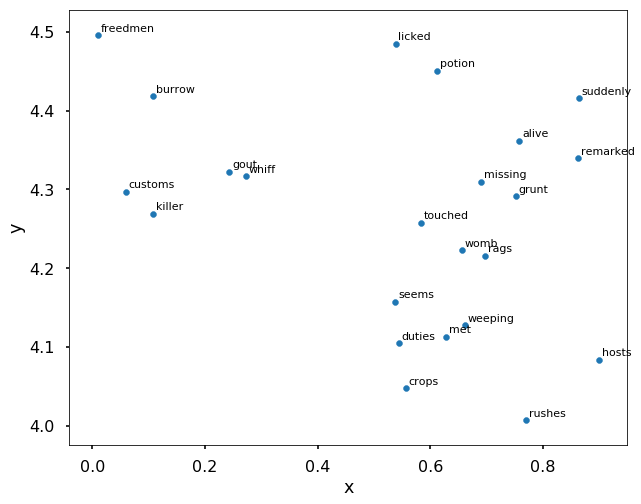

In [343]:
plot_region(x_bounds=(0, 1), y_bounds=(4, 4.5))

### Explore semantic similarities between book characters

**Words closest to the given word**

In [345]:
model.wv.most_similar("man")

2018-04-14 19:53:14,038 : INFO : precomputing L2-norms of word weight vectors


[('men', 0.4106009602546692),
 ('woman', 0.3922725021839142),
 ('lascivious', 0.37766310572624207),
 ('he', 0.37721508741378784),
 ('teamster', 0.3683393597602844),
 ('said', 0.36649829149246216),
 ('tybero', 0.366401731967926),
 ('unforgiving', 0.36490994691848755),
 ('lawyer', 0.3624509572982788),
 ('one', 0.36006850004196167)]

**Linear relationships between word pairs**

In [346]:
def nearest_similarity_cosmul(start1, end1, end2, correct=''):
    try:
        similarities = model.wv.most_similar_cosmul(
            positive=[end2, start1],
            negative=[end1]
        )
        s = [x[0] for x in similarities]
        start2 = s[0]
        
        if start2 == correct:
            print("{start1} is related to {end1}, as {start2} is related to {end2} ({correct})".format(**locals()))    
            return "correct"
        elif correct in s:
            print("{start1} is related to {end1}, as {start2} is related to {end2} ({correct})".format(**locals()))    
            return "almost"
        else:
            return "incorrect"
        
        return 'x'

        print("{start1} is related to {end1}, as {start2} is related to {end2} ({correct})".format(**locals()))
        try:
            print(s.index(correct))
        except:
            print('correct not in similarities')
        return start2
    except KeyError:
        return "OOV"

In [357]:
with open('/Users/zingbretsen/Documents/github/GloVe/eval/question-data/gram7-past-tense.txt', 'r') as f:
    lines = f.readlines()

results = {
    'correct': 0, 
    'incorrect': 0,
    'almost': 0,
    'OOV': 0
}

for line in lines:
    line = line.strip().split()

    result = nearest_similarity_cosmul(line[0], line[1], line[3], line[2])
    results[result] += 1

total = sum(list(results.values()))
print("Correct: {}/{}".format(results['correct'], total))
print("Almost: {}/{}".format(results['almost'], total))

dancing is related to danced, as flapping is related to flew (flying)
dancing is related to danced, as mummery is related to played (playing)
dancing is related to danced, as letter is related to read (reading)
dancing is related to danced, as relished is related to spent (spending)
dancing is related to danced, as take is related to took (taking)
describing is related to described, as sneer is related to played (playing)
describing is related to described, as madly is related to screamed (screaming)
describing is related to described, as chanted is related to sang (singing)
describing is related to described, as droop is related to slept (sleeping)
describing is related to described, as vanish is related to vanished (vanishing)
falling is related to fell, as moving is related to moved (moving)
falling is related to fell, as playing is related to played (playing)
falling is related to fell, as rivulets is related to ran (running)
falling is related to fell, as vanish is related to vani

thinking is related to thought, as listening is related to listened (listening)
thinking is related to thought, as play is related to played (playing)
thinking is related to thought, as reading is related to read (reading)
thinking is related to thought, as bed is related to slept (sleeping)
vanishing is related to vanished, as skies is related to walked (walking)
vanishing is related to vanished, as sleeping is related to slept (sleeping)
vanishing is related to vanished, as situation is related to struck (striking)
walking is related to walked, as folly is related to fell (falling)
walking is related to walked, as ups is related to moved (moving)
walking is related to walked, as playing is related to played (playing)
walking is related to walked, as folly is related to screamed (screaming)
writing is related to wrote, as game is related to played (playing)
writing is related to wrote, as i is related to said (saying)
writing is related to wrote, as madly is related to screamed (screa